In [24]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from itertools import product

## Func

In [25]:
def _pad(X, k):
    XX_shape = tuple(np.subtract(X.shape, k.shape) + (1, 1))
    if XX_shape!=X.shape:
        P = np.subtract(X.shape, XX_shape) // 2
        MD = np.subtract(X.shape, XX_shape) % 2
        X_ = np.pad(X, ((P[0], P[0]+MD[0]), (P[1], P[1]+MD[1])), 'constant')
    else:
        X_ = np.copy(X)
    return X_

def _DSP(X, k, iter=1):
    for i in range(iter):
        k_ = k / (k.shape[0] * k.shape[1])
        X_pad = _pad(X, k_)
        view_shape = tuple(np.subtract(X_pad.shape, k_.shape) + 1) + k_.shape
        strides = X_pad.strides + X_pad.strides
        sub_matrices = as_strided(X_pad, view_shape, strides) 
        cv = np.einsum('klij,ij->kl', sub_matrices, k_)
        X = cv[::2, ::2]
    return X

def _USP(DP, k, iter=1):
    for i in range(iter):
        DP_ = np.insert(DP, range(DP.shape[0]), 0, axis=0)
        X = np.insert(DP_, range(DP.shape[1]), 0, axis=1)
        k_ = k / (k.shape[0] * k.shape[1])
        X_pad = _pad(X, k_)
        view_shape = tuple(np.subtract(X_pad.shape, k_.shape) + 1) + k_.shape
        strides = X_pad.strides + X_pad.strides
        sub_matrices = as_strided(X_pad, view_shape, strides) 
        DP = np.einsum('klij,ij->kl', sub_matrices, k_)
    return DP

def _nor(X, h, w):
    X_ = X - np.sum(X) / (h*w)
    return X_

def _CC(X, Y):
    res = np.sum(X * Y) / np.sqrt(np.sum(X**2) * np.sum(Y**2))
    return res

def _sub(I, T):
    view_shape = tuple(np.subtract(I.shape, T.shape) + 1) + T.shape
    strides = I.strides + I.strides
    sub_matrices = as_strided(I, view_shape, strides)
    return sub_matrices

def _match(sub_matrices, T):
    h_, w_, h, w = sub_matrices.shape
    L = []
    T_ = _nor(T, h, w)
    for y, x in product(range(h_), range(w_)):
        S_ = _nor(sub_matrices[y, x, :, :], h, w)
        L.append(_CC(T_, S_))
    res = np.array(L).reshape(h_, w_)
    return res

def _split(path, img_type='100'):
    tot_list = os.listdir(path)
    img_list, tpl_list = [], []
    for j in tot_list:
        k = j.replace('.', '-')
        if k.split('-')[0]==img_type and k.split('-')[-2]!='MatchResult':
            if k.split('-')[-2]=='Template':
                tpl_list.append(j)
            else:
                img_list.append(j)
    return img_list, tpl_list

## path

In [26]:
path = '../img'
img_list, tpl_list = _split(path, img_type='100')

## img

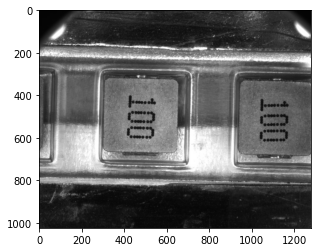

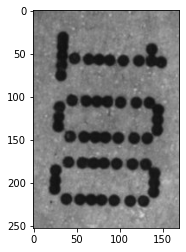

In [27]:
img_org = cv2.imread(os.path.join(path, img_list[0]))
tpl = cv2.imread(os.path.join(path, tpl_list[0]))

fig = plt.figure()
plt.imshow(img_org)

fig = plt.figure()
plt.imshow(tpl)

## View

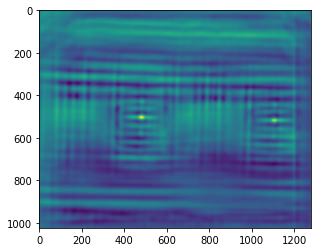

In [28]:
I_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
T_org = cv2.cvtColor(tpl, cv2.COLOR_BGR2GRAY)

G = np.array([[1,  4,  6,  4, 1],
              [4, 16, 24, 16, 4],
              [6, 24, 36, 24, 6],
              [4, 16, 24, 16, 4],
              [1,  4,  6,  4, 1]])
I = _DSP(I_org, G/16, iter=3)
T = _DSP(T_org, G/16, iter=3)
I_pad = _pad(I, T)

sub_matrices = _sub(I_pad, T)
CC = _match(sub_matrices, T)

res = _USP(CC, G/4, iter=3)

fig = plt.figure()
plt.imshow(res)


## Box_Cent

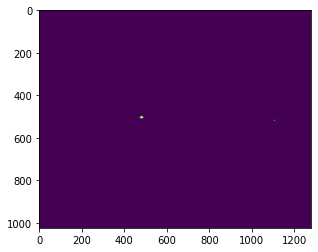

In [29]:

M = np.where(res>0.13, 1, 0)

fig = plt.figure()
plt.imshow(M)

## Boxes

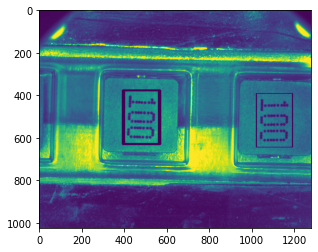

In [30]:
box_i, box_j = np.where(M!=0)
h, w = T_org.shape

# y, x
boxes = np.vstack([box_j - w//2, box_i - h//2,\
                   box_j + w//2, box_i + h//2]).T

I_box = np.copy(I_org)
for i in range(len(boxes)):
    x1, y1 = boxes[i, :2]
    x2, y2 = boxes[i, 2:]
    cv2.rectangle(I_box, (x1, y1), (x2, y2), (0, 255, 0), 1)

fig = plt.figure()
plt.imshow(I_box)